In [138]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.integrate as spint
import scipy.io as sio
from os.path import isfile, isdir

# Enable interactive figures for latest versions of Jupyter Lab, with 'jupyter-matplotlib' 'widgetsnbextension' installed and activated.
#%matplotlib widget
# If no figure is showing, replace with
%matplotlib inline

In [139]:
def lorenz(t, xyz, s=10, r=28, b=8 / 3):
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot

In [140]:
# For the purposes of this exercise, we can take larger time steps
dt = 0.05
T_end = 25

try:
    data = sio.loadmat('data/lorenz_det_data.mat')
    Train_data = data['Train_data']
    Val_data = data['Val_data']
    N_exp = Train_data.shape[2]
    N_val = Val_data.shape[2]
    t = np.linspace(0, T_end, Train_data.shape[1])
    print('Lorenz trajectories imported from file')
    
# if not existing, generate new ones
except FileNotFoundError:
    N_exp = 400    # Number of experiments in the training set
    N_val = 100    # Number of experiments in the validatio nset
    t = np.arange(0, T_end, dt)
    Train_data = np.empty((3, t.shape[0], 0))
    Val_data = np.empty((3, t.shape[0], 0))

    fig = plt.figure(1)
    ax = plt.axes(projection='3d')
    for i in range(0, N_exp + N_val):
        y0 = 30 * (np.random.random((3,)) - 0.5)

        sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t, atol=1e-10, rtol=1e-9)

        if i >= N_exp + N_val - 3:
            ax.plot3D(sol.y[0, :], sol.y[1, :], sol.y[2, :])
        if i < N_exp:
            Train_data = np.dstack((Train_data, sol.y))
            if np.not_equal(sol.y, Train_data[:, :, -1]).any():
                print('Strange stuff is happening here!')
        else:
            Val_data = np.dstack((Val_data, sol.y))
            if np.not_equal(sol.y, Val_data[:, :, -1]).any():
                print('Strange stuff is happening here!')
    sio.savemat('data/lorenz_det_data.mat',
                {'Train_data': Train_data, 'Val_data': Val_data}, do_compression = True)
    print('Lorenz trajectories dumped to file')

Lorenz trajectories imported from file


In [109]:
# Data standardization
norm_mean = np.mean(Train_data, axis=(1, 2)).reshape((3, 1))
norm_std = np.std(Train_data, axis=(1, 2)).reshape((3, 1))

Data = np.concatenate((Train_data, Val_data), axis=2)

for i in range(0, 3):
    Data[i, :, :] = (Data[i, :, :] - norm_mean[i]) / norm_std[i]

In [110]:
# Data labeling
# To label the data, we setup the following criterion: any datapoint of the training set is composed by t1 
# past values of (x,y,z), and it is associated to the label "1" if in the next t2 time instants the the 
# trajectory trenspasses the plane dividing the two centers of trajectories, C1 and C2, or "0" otherwise.

t1 = 6  # How much past steps we consider for the prediction
t2 = 12  # Horizon for the lobe change prediction
beta = 8 / 3
rho = 28

# C1 = ( -sqrt(-beta+beta*rho), -sqrt(-beta+beta*rho), -1+rho)
# C2 = (  sqrt(-beta+beta*rho),  sqrt(-beta+beta*rho), -1+rho)
# Then normalize, compute the mean point and the vector, which is the normal vector to the plane

pi_n = np.array([[2 * (np.sqrt(-beta + beta * rho) - norm_mean[0]) / norm_std[0],
                  2 * (np.sqrt(-beta + beta * rho) - norm_mean[1]) / norm_std[2],
                  0]])  # Coefficients of the (normalized) threshold plane separating the two lobes
# Remark: homogeneous plane (O \in pi_n)

In [111]:
# Now we can build the training and validation sets with the labels
_t_steps = np.arange(t1, t.shape[0] - t2, round(t1 / 2))
X = np.empty((3 * t1, _t_steps.shape[0], 0))
Y = np.empty((1, _t_steps.shape[0], 0))

for k in range(0, Data.shape[2]):
    _X_exp = np.empty((3 * t1, 0))
    _Y_exp = np.empty((1, 0))
    for tau in _t_steps:
        _x_past = Data[:, tau - t1:tau, k]
        _x_future = Data[:, tau:tau + t2, k]
        _X_exp = np.append(_X_exp, _x_past.T.reshape((-1, 1)), axis=1)
        _proj = pi_n @ _x_future
        _y = np.any(_proj > 0) and np.any(_proj < 0)
        _Y_exp = np.append(_Y_exp, _y.reshape((-1, 1)), axis=1)
    X = np.dstack((X, _X_exp))
    Y = np.dstack((Y, _Y_exp))

X_train_norm = X[:, :, 0]
Y_train_norm = Y[:, :, 0]
X_val_norm = X[:, :, N_exp]
Y_val_norm = Y[:, :, N_exp]

# Make the training and validation sets 2D
for i in range(1, N_exp):
    X_train_norm = np.append(X_train_norm, X[:, :, i], axis=1)
    Y_train_norm = np.append(Y_train_norm, Y[:, :, i], axis=1)
for i in range(N_exp + 1, N_val):
    X_val_norm = np.append(X_val_norm, X[:, :, i], axis=1)
    Y_val_norm = np.append(Y_val_norm, Y[:, :, i], axis=1)

In [123]:
# Train a NN to forecast the future label
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import os
from pathlib import Path

_nn_path = str(Path('saved/trained_network_part3b'))  # This ensures robustness wrt the OS

if not tf.__version__.startswith('2'):
    tf.enable_eager_execution()

if isfile(_nn_path) or isdir(_nn_path):
    nn = tf.keras.models.load_model(_nn_path)
    print('Pre-loaded NN model imported')
else:
    class CatchUserInterruptCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if isfile('STOP.txt'):
                print('Stopping on user request...')
                self.stopped_epoch = epoch
                self.model.stop_training = True
                os.remove('STOP.txt')

    # This is a quite simple MLP 
    x0 = Input(shape=(X_train_norm.shape[0],))
    x1 = Dense(units=50, activation='tanh')(x0)
    x2 = LeakyReLU(alpha=0.05)(Dense(units=50)(x1))
    x3 = Dense(units=10, activation='tanh')(x2)
    x4 = LeakyReLU(alpha=0.05)(Dense(units=10)(x3))
    x5 = Dense(units=1, activation='sigmoid')(x4)

    nn = Model(x0, x5)
    # we take the Binary Cross Entropy as loss function, and use the forecast accuracy as metric
    nn.compile(tf.keras.optimizers.Adam(4e-4), loss=BinaryCrossentropy(), metrics=['acc'])
    esr = EarlyStopping(monitor='val_acc', verbose=1, restore_best_weights=True, patience=100)
    nn.summary()
    nn.fit(X_train_norm.T, Y_train_norm.T, validation_data=(X_val_norm.T, Y_val_norm.T),
           epochs=2000, batch_size=100, shuffle=True, callbacks=[CatchUserInterruptCallback(), esr])
    nn.save(_nn_path)
    print("Neural network trained and dumped to file")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0     

In [134]:
# To test the NN we build an independent test set generating new trajectories.
dt_sim = 0.01  # Simulation is done a smaller time-step for plotting, and then downsampled
t_sim = np.arange(0, T_end, dt_sim)

y0 = 30 * (np.random.random((3,)) - 0.5)
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t_sim, atol=1e-10, rtol=1e-9)
sol_true = sol.y[0:3, :]
resampling = round(dt / dt_sim)  # Always make sure that dt is an integer-multiple of dt_sim
Data_test = (sol_true[:, ::resampling] - norm_mean) / norm_std

In [135]:
# Define the ground truth, i.e. when the simulated trajectories cross the threshold plane.
_proj = pi_n @ ((sol_true - norm_mean) / norm_std)
zero_crossings = np.where(np.diff(np.sign(_proj), axis=1))[1]
lobe_change_instants = t_sim[zero_crossings] + dt_sim / 2
lobe_change_coords = (sol_true[:, zero_crossings] + sol_true[:, zero_crossings + 1]) / 2

# Simulate the NN and compare the produced labels to the ground truth
_t_steps = np.arange(t1, t.shape[0] - t2, round(t1 / 2))

X_test = np.empty((3 * t1, 0))
Y_test = np.empty((1, 0))
Y_nn = np.empty((1, 0))

for tau in _t_steps:
    _x_past = Data_test[:, tau - t1:tau]
    _x_future = Data_test[:, tau:tau + t2]
    _proj = pi_n @ _x_future
    _y = np.any(_proj > 0) and np.any(_proj < 0)
    X_test = np.append(X_test, _x_past.T.reshape((-1, 1)), axis=1)
    Y_test = np.append(Y_test, _y.reshape((-1, 1)), axis=1)

t_nn = np.arange(0, T_end, dt)[_t_steps]
Y_nn = np.round(nn.predict(X_test.T).T)
test_accuracy = 1 -  np.sum(np.abs(Y_nn - Y_test)) / Y_nn.shape[1]
print('Accuracy on the test experiment: {}%'.format(test_accuracy*100))

Accuracy on the test experiment: 98.75776397515527%


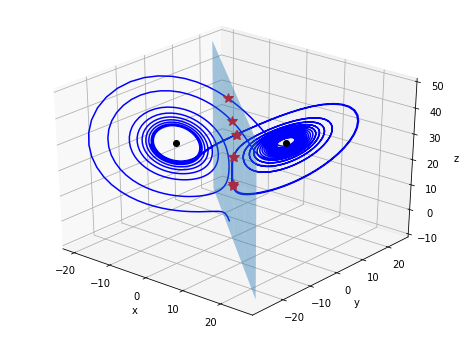

In [136]:
# Plotting
xx, zz = np.meshgrid(np.linspace(-20, 25, 5), np.linspace(-10, 50, 5))
yy = - (pi_n[0, 0] * xx + pi_n[0, 2] * zz) / pi_n[0, 1]

fig = plt.figure(figsize=(8,6))
ax3 = plt.axes(projection='3d')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.plot3D(sol_true[0, :], sol_true[1, :], sol_true[2, :], 'b')
ax3.plot_surface(xx, yy, zz, alpha=0.4)
ax3.plot3D(lobe_change_coords[0, :], lobe_change_coords[1, :], lobe_change_coords[2, :],
           marker='*',
           markerfacecolor='r',
           markeredgecolor='r',
           markersize=10,
           linestyle='None')
ax3.plot3D(np.array([-np.sqrt(-beta+beta*rho), np.sqrt(-beta+beta*rho)]), 
           np.array([-np.sqrt(-beta+beta*rho), np.sqrt(-beta+beta*rho)]), 
           np.array([-1+rho, -1+rho]), 
           marker='o',
           markerfacecolor='k',
           markeredgecolor='k',
           linestyle='None')
ax3.view_init(30, -50)
plt.savefig('figs/Lor_detection_3D.png')

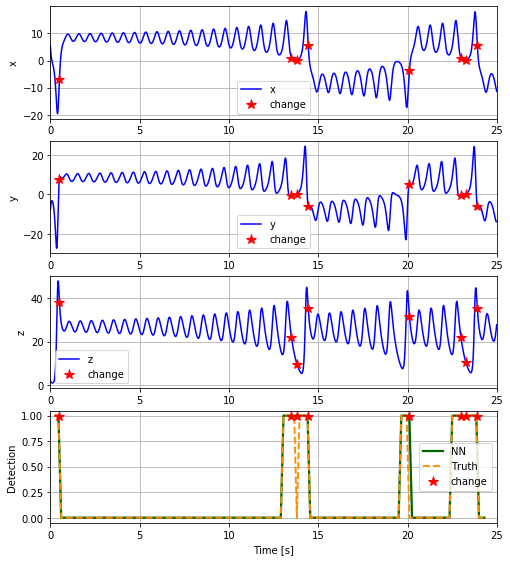

In [137]:
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 9.5))

ax1.plot(t_sim, sol_true[0, :], 'b')
ax1.plot(lobe_change_instants, lobe_change_coords[0, :],
         marker='*',
         markerfacecolor='r',
         markeredgecolor='r',
         markersize=9.5,
         linestyle='None')
ax1.grid()
ax1.axis(xmin=0, xmax=T_end)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('x')
ax1.legend(('x', 'change'))

ax2.plot(t_sim, sol_true[1, :], 'b')
ax2.plot(lobe_change_instants, lobe_change_coords[1, :],
         marker='*',
         markerfacecolor='r',
         markeredgecolor='r',
         markersize=9.5,
         linestyle='None')
ax2.grid()
ax2.axis(xmin=0, xmax=T_end)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("y")
ax2.legend(('y', 'change'))

ax3.plot(t_sim, sol_true[2, :], 'b')
ax3.plot(lobe_change_instants, lobe_change_coords[2, :],
         marker='*',
         markerfacecolor='r',
         markeredgecolor='r',
         markersize=9.5,
         linestyle='None')
ax3.grid()
ax3.axis(xmin=0, xmax=T_end)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("z")
ax3.legend(('z', 'change'))

ax4.plot(t_nn, Y_test[0, :], color='darkgreen', linestyle='-', linewidth=2.25)
ax4.plot(t_nn, Y_nn[0, :], color='darkorange', linestyle='--', linewidth=1.88)
ax4.plot(lobe_change_instants, np.ones(lobe_change_instants.shape),
         marker='*',
         markerfacecolor='r',
         markeredgecolor='r',
         markersize=9.5,
         linestyle='None')
ax4.grid()
ax4.axis(xmin=0, xmax=T_end)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Detection')
ax4.legend(('NN', 'Truth', 'change'))
plt.savefig('figs/Lor_detection.png')